In [1]:
import os
import glob
import cv2
import imageio
import base64
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
import torchvision
from torchvision.utils import make_grid
from torchvision import datasets, models
from torch.utils.data import Dataset, DataLoader
from fastai.data.external import untar_data, URLs
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet
from google.colab import files


In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [193]:
#from someone else's github -- https://colab.research.google.com/github/mberkay0/image-colorization/blob/main/ImageColorization.ipynb#scrollTo=xE-uUStuv1Nl
seed = 123
fit = False
SIZE = 256
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"

paths = glob.glob(coco_path + "/*.jpg") # Grabbing all the image file names
np.random.seed(seed)
paths_subset = np.random.choice(paths, 10_000, replace=False) # choosing 10000 images randomly
rand_idxs = np.random.permutation(10_000)
train_idxs = rand_idxs[:8000] # choosing the first 8000 as training set
val_idxs = rand_idxs[8000:] # choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]

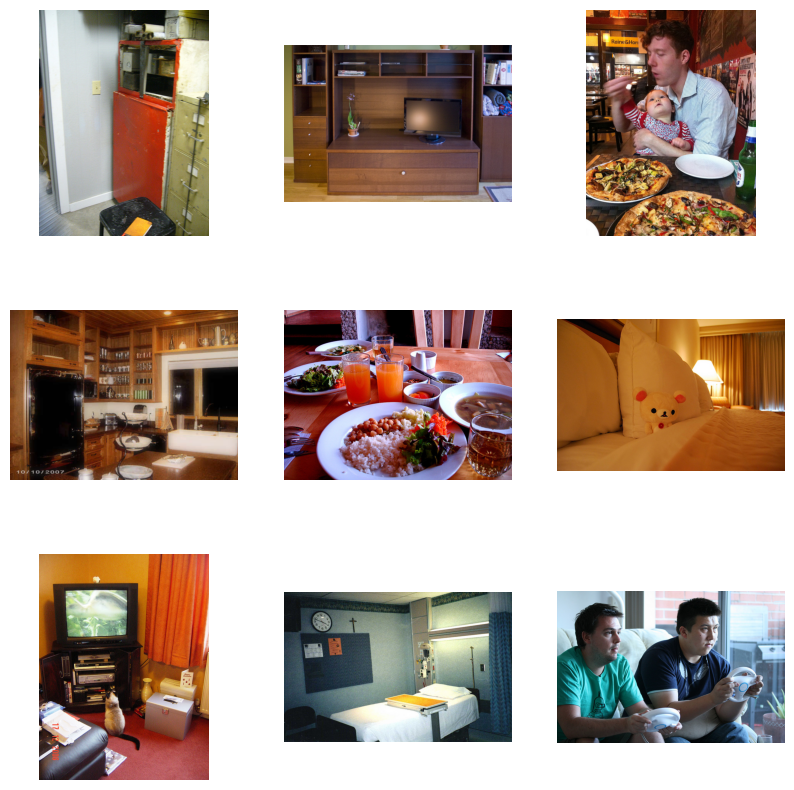

In [194]:
_, axes = plt.subplots(3, 3, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

In [341]:
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((256, 256),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((256, 256),  Image.BICUBIC)

        self.split = split
        self.size = SIZE
        self.paths = paths

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1

        return L, ab

    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=16, n_workers=2, pin_memory=True, **kwargs):
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [342]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

In [317]:
#Don't run this just don't want to delete it yet
class Colorize(nn.Module):
    def __init__(self):
        super(Colorize, self).__init__()

        # Define the convolutional layers
        self.conv_layers = nn.Sequential(
            # Input: 1 channel (grayscale), Output: 64 channels, Kernel size: 3x3, Stride: 1
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            # Output layer
            nn.Conv2d(256, 2, kernel_size=1, stride=1, padding=0)  # Adjusted output channels to match target
        )

        # Upsampling layer
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')  # Adjusted upsampling factor

    def forward(self, input_l):
        # Forward pass through convolutional layers
        conv_output = self.conv_layers(input_l)
        # Upsample the output
        output = self.upsample(conv_output)
        return output

# Instantiate the model
model = Colorize().to(device)


In [371]:
import torch.nn as nn
import torchvision.models as models


class Net(nn.Module):
  def __init__(self, input_size=128):
    super(Net, self).__init__()
    resnet = models.resnet34(num_classes=1000)
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1))
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])
    RESNET_FEATURE_SIZE = 128

    self.upsample = nn.Sequential(
      nn.Conv2d(RESNET_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(16),
      nn.ReLU(),
      nn.Conv2d(16, 2, kernel_size=3, stride=1, padding=1), # Output has 2 channels instead of 3 because we are
                                                          # predicting a and b channels of Lab color space instead of RGB
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):
    midlevel_features = self.midlevel_resnet(input)
    output = self.upsample(midlevel_features)
    return output

model = Net().to(device)

In [372]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [373]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (grayscale_imgs, colorized_imgs) in enumerate(train_dl):
        grayscale_imgs = grayscale_imgs.to(device)
        colorized_imgs = colorized_imgs.to(device)
        optimizer.zero_grad()
        outputs = model(grayscale_imgs)
        loss = criterion(outputs, colorized_imgs)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/50], Loss: 0.0135
Epoch [2/50], Loss: 0.0133
Epoch [3/50], Loss: 0.0133
Epoch [4/50], Loss: 0.0133
Epoch [5/50], Loss: 0.0133
Epoch [6/50], Loss: 0.0132
Epoch [7/50], Loss: 0.0131
Epoch [8/50], Loss: 0.0132
Epoch [9/50], Loss: 0.0132
Epoch [10/50], Loss: 0.0131
Epoch [11/50], Loss: 0.0133
Epoch [12/50], Loss: 0.0132
Epoch [13/50], Loss: 0.0130
Epoch [14/50], Loss: 0.0131
Epoch [15/50], Loss: 0.0131
Epoch [16/50], Loss: 0.0131
Epoch [17/50], Loss: 0.0129
Epoch [18/50], Loss: 0.0130
Epoch [19/50], Loss: 0.0130
Epoch [20/50], Loss: 0.0128
Epoch [21/50], Loss: 0.0128
Epoch [22/50], Loss: 0.0128
Epoch [23/50], Loss: 0.0128
Epoch [24/50], Loss: 0.0128
Epoch [25/50], Loss: 0.0127
Epoch [26/50], Loss: 0.0126
Epoch [27/50], Loss: 0.0125
Epoch [28/50], Loss: 0.0126
Epoch [29/50], Loss: 0.0126
Epoch [30/50], Loss: 0.0124
Epoch [31/50], Loss: 0.0123
Epoch [32/50], Loss: 0.0121
Epoch [33/50], Loss: 0.0117
Epoch [34/50], Loss: 0.0119
Epoch [35/50], Loss: 0.0116
Epoch [36/50], Loss: 0.0111
E

In [374]:
def combine_and_convert(lab_l, lab_ab):
    lab_ab = lab_ab.to(lab_l.device)
    combined_lab = torch.cat((lab_l, lab_ab), dim=1)

    combined_lab = combined_lab.permute(0, 2, 3, 1)

    colorized_rgb = lab2rgb(combined_lab.cpu())
    colorized_rgb = np.clip(colorized_rgb, 0, 1)
    return colorized_rgb



In [375]:
def evaluate_model(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(dataloader, 0):
            inputs, targets = batch[0].to(device), batch[1].to(device)

            outputs_ab = model(inputs)

            inputs = inputs * 100
            outputs_ab = outputs_ab * 255
            targets = targets * 255

            # Combine L channel with predicted AB channels
            colorized_rgb = combine_and_convert(inputs, outputs_ab)
            targets_rgb = combine_and_convert(inputs, targets)

            if i == 0:
                for j in range(len(inputs)):
                    visualize_example(inputs[j], colorized_rgb[j], targets_rgb[j])
            break


In [376]:
def visualize_example(grayscale, colorized_pred, colorized_gt):

    grayscale = grayscale.squeeze().cpu().numpy()

    # Plot images
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(grayscale, cmap='gray')
    axes[0].set_title('Grayscale')
    axes[0].axis('off')
    axes[1].imshow(colorized_pred)
    axes[1].set_title('Predicted Colorized')
    axes[1].axis('off')
    axes[2].imshow(colorized_gt)
    axes[2].set_title('Ground Truth Colorized')
    axes[2].axis('off')
    plt.show()


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 568708 pixels
  return func(*args, **kwargs)


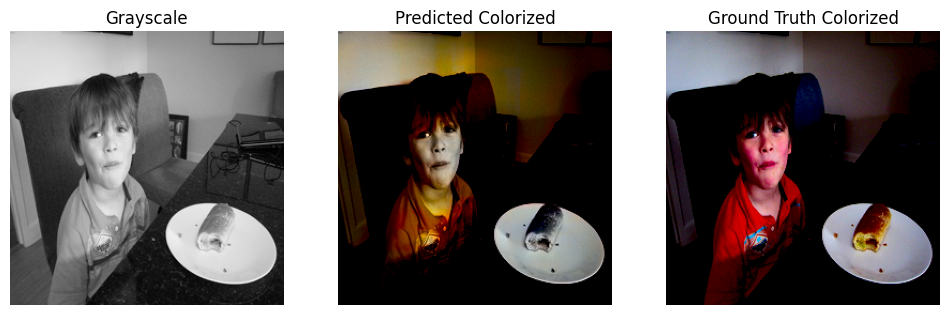

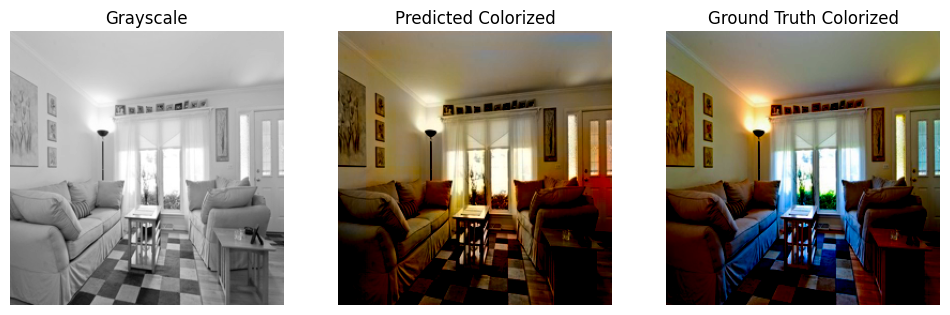

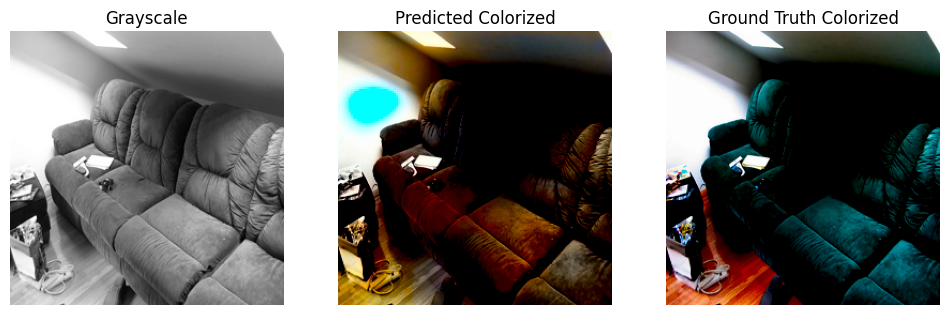

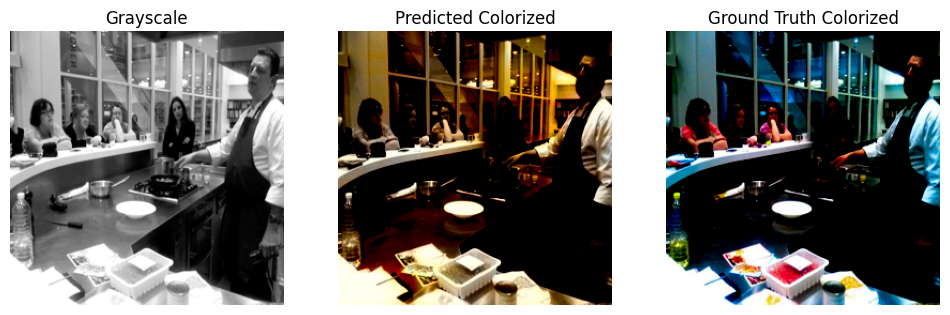

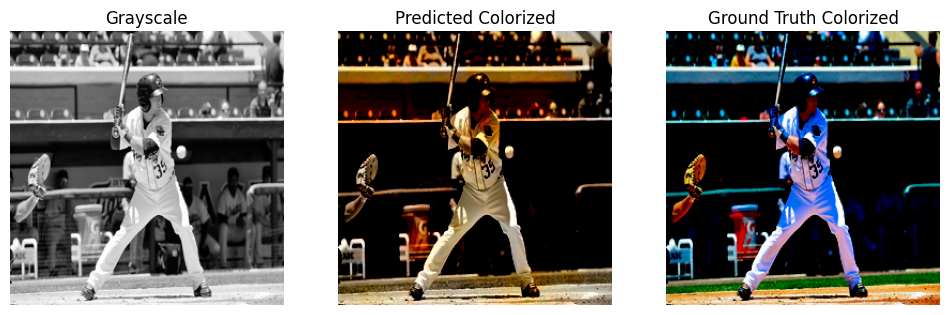

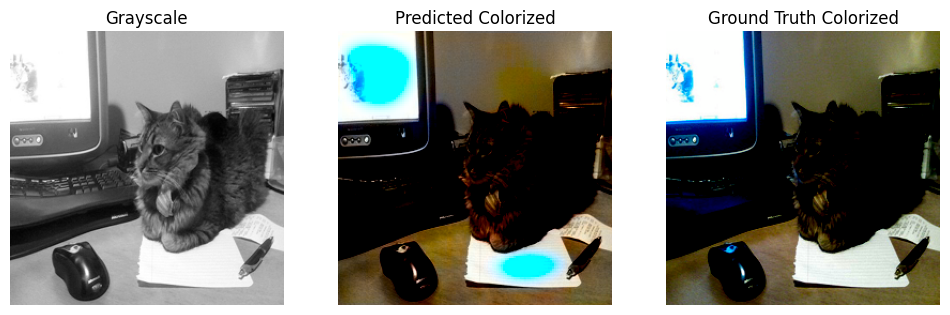

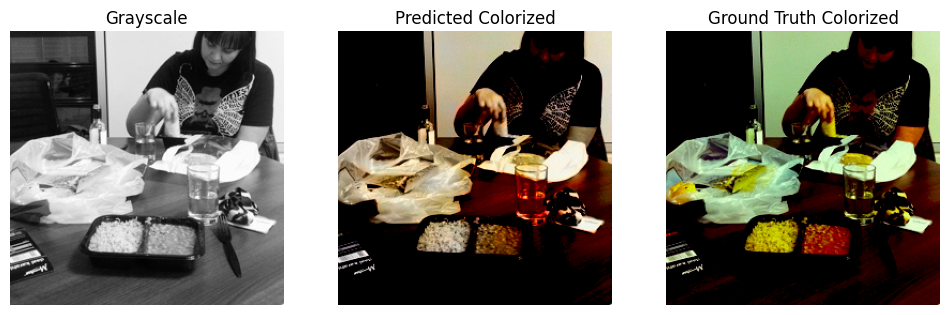

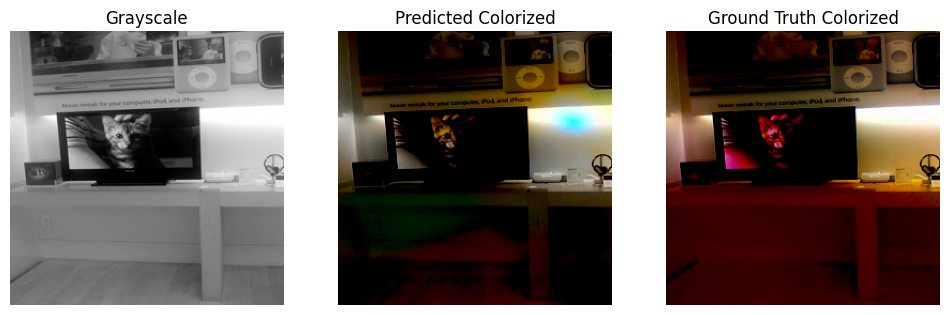

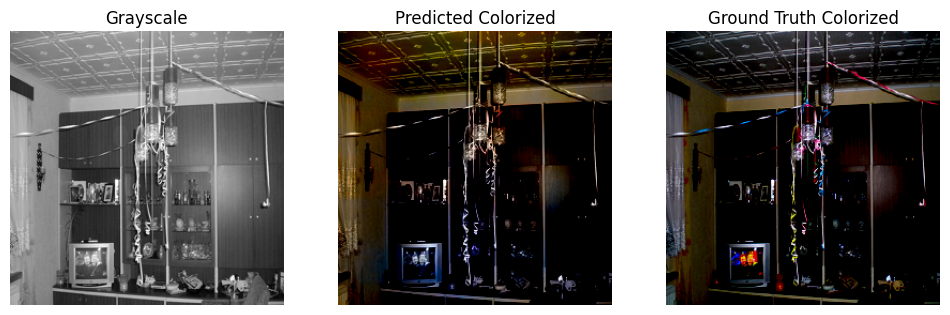

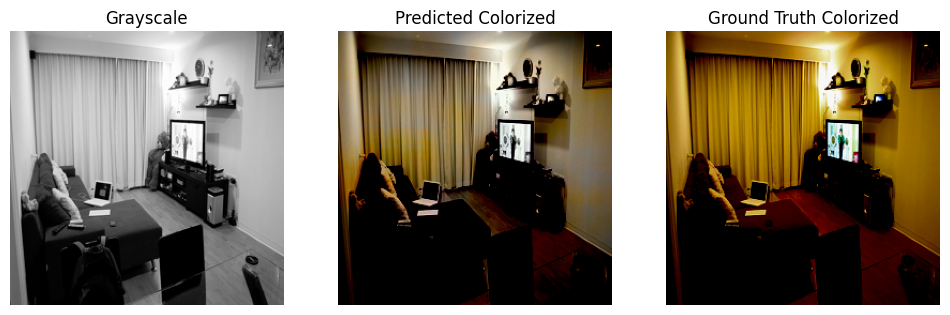

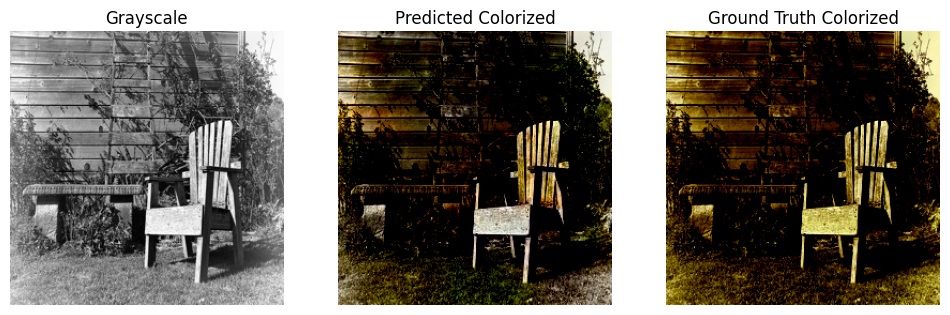

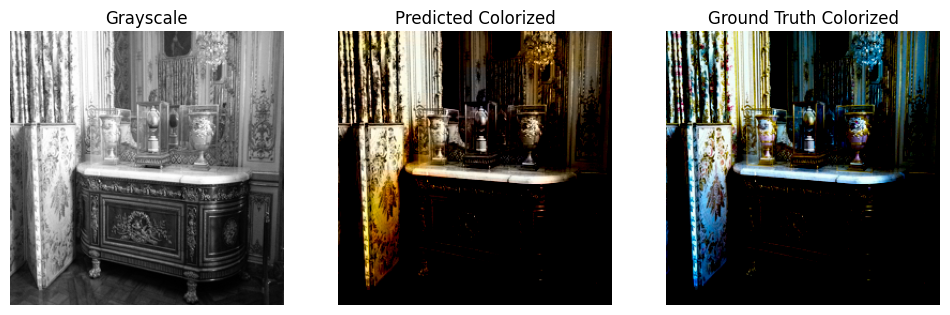

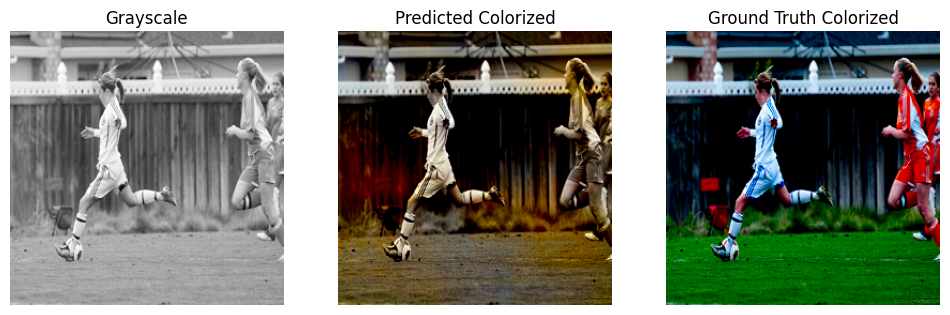

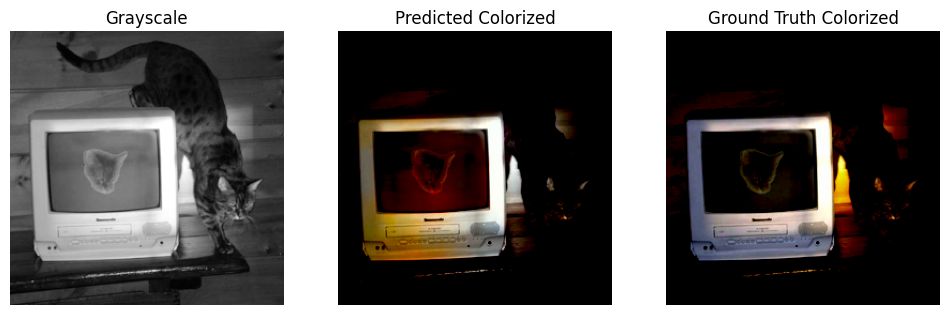

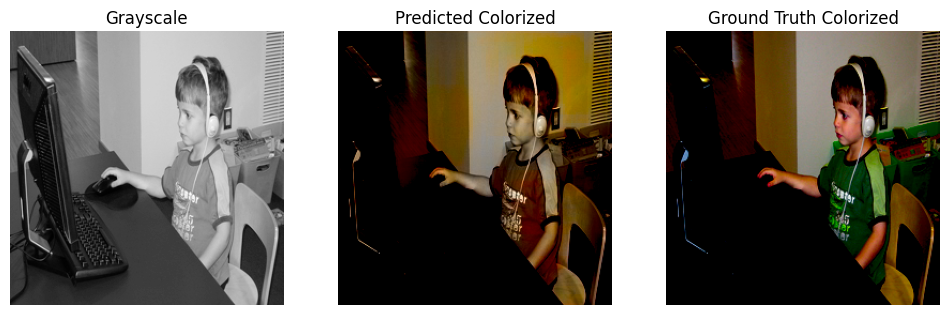

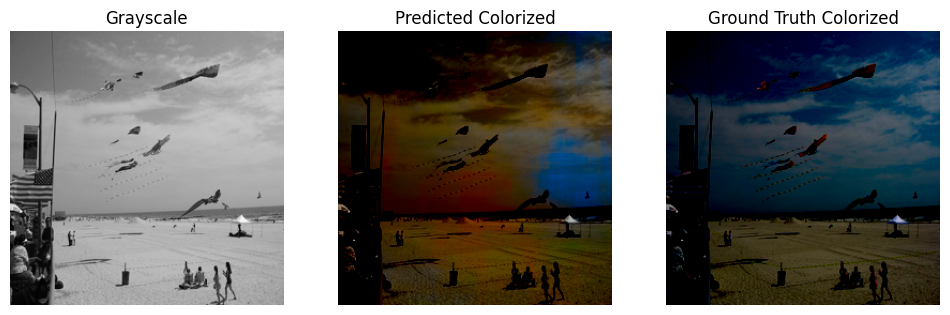

In [377]:
evaluate_model(model, val_dl, device)